**GStore Dataset Revenue Prediction**

About the dataset:

Each row in the dataset is one visit to the store. We are predicting the natural log(In) of the sum of all transactions per user.

**fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.  
**channelGrouping** - The channel via which the user came to the Store.  
**date** - The date on which the user visited the Store.  
**device** - The specifications for the device used to access the Store.  
**geoNetwork** - This section contains information about the geography of the user.  
**sessionId** - A unique identifier for this visit to the store.  
**socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".  
**totals** - This section contains aggregate values across the session.  
**trafficSource** - This section contains information about the Traffic Source from which the session originated.  
**visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.  
**visitNumber** - The session number for this user. If this is the first session, then this is set to 1.  
**visitStartTime** - The timestamp (expressed as POSIX time).  

Also it is important to note that some of the fields are in json format.

 As generally used in many other competitions, we can convert all the json fields in the file to a  csv format. Thanks  Julian for the excellent kernel.

In [31]:
import numpy as np
import pandas as pd
import json
import os
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
data = pd.read_csv('DataMerged.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,5,6,13,45,46,48,49,51,54,78,80,82,83,84,85,89,90,91,92,93,114,115,118,119,126,127,131) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
data.head()

,channelGrouping,customDimensions,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,hits.appInfo.exitScreenName,hits.appInfo.landingScreenName,hits.appInfo.screenDepth,hits.appInfo.screenName,hits.contentGroup.contentGroup1,hits.contentGroup.contentGroup2,hits.contentGroup.contentGroup3,hits.contentGroup.contentGroup4,hits.contentGroup.contentGroup5,hits.contentGroup.contentGroupUniqueViews1,hits.contentGroup.contentGroupUniqueViews2,hits.contentGroup.contentGroupUniqueViews3,hits.contentGroup.previousContentGroup1,hits.contentGroup.previousContentGroup2,hits.contentGroup.previousContentGroup3,hits.contentGroup.previousContentGroup4,hits.contentGroup.previousContentGroup5,hits.customDimensions,hits.customMetrics,hits.customVariables,hits.dataSource,hits.eCommerceAction.action_type,hits.eCommerceAction.option,hits.eCommerceAction.step,hits.eventInfo.eventAction,hits.eventInfo.eventCategory,hits.eventInfo.eventLabel,hits.exceptionInfo.isFatal,hits.experiment,hits.hitNumber,hits.hour,hits.isEntrance,hits.isExit,hits.isInteraction,hits.item.currencyCode,hits.item.transactionId,hits.latencyTracking.domContentLoadedTime,hits.latencyTracking.domInteractiveTime,hits.latencyTracking.domLatencyMetricsSample,hits.latencyTracking.domainLookupTime,hits.latencyTracking.pageDownloadTime,hits.latencyTracking.pageLoadSample,hits.latencyTracking.pageLoadTime,hits.latencyTracking.redirectionTime,hits.latencyTracking.serverConnectionTime,hits.latencyTracking.serverResponseTime,hits.latencyTracking.speedMetricsSample,hits.minute,hits.null,hits.page.hostname,hits.page.pagePath,hits.page.pagePathLevel1,hits.page.pagePathLevel2,hits.page.pagePathLevel3,hits.page.pagePathLevel4,hits.page.pageTitle,hits.page.searchCategory,hits.page.searchKeyword,hits.product,hits.promotion,hits.promotionActionInfo.promoIsClick,hits.promotionActionInfo.promoIsView,hits.publisher_infos,hits.referer,hits.social.hasSocialSourceReferral,hits.social.socialInteractionNetworkAction,hits.social.socialNetwork,hits.time,hits.transaction.affiliation,hits.transaction.currencyCode,hits.transaction.localTransactionRevenue,hits.transaction.localTransactionShipping,hits.transaction.localTransactionTax,hits.transaction.transactionId,hits.transaction.transactionRevenue,hits.transaction.transactionShipping,hits.transaction.transactionTax,hits.type
0,Organic Search,EMEA,20171016,3162355547410993243,Not Socially Engaged,1.5082e+09,1,1.508198e+09,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo da

In [34]:
data.shape

(1708345, 136)

In [35]:
(data.notnull().sum()==0).sum()

1

In [36]:
constant_cols = data.nunique()[(data.nunique()<=1)].index
constant_cols

Index(['device.browserSize', 'device.browserVersion', 'device.flashVersion',
       'device.mobileDeviceBranding', 'device.mobileDeviceInfo',
       'device.mobileDeviceMarketingName', 'device.mobileDeviceModel',
       'device.mobileInputSelector', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId',
       'geoNetwork.latitude', 'geoNetwork.longitude',
       'geoNetwork.networkLocation', 'totals.bounces', 'totals.newVisits',
       'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.isTrueDirect', 'hits.appInfo.screenDepth',
       'hits.contentGroup.contentGroup4', 'hits.contentGroup.contentGroup5',
       'hits.contentGroup.contentGroupUniqueViews1',
       'hits.contentGroup.contentGroupUniqueViews2',
       'hits.contentGroup.contentGroupUniqueViews3',
       'hits.contentGroup.previousContentGroup1',
       'hits.contentGroup.previ

In [39]:
def find_revenue(cols):
    const_cols = []
    for col_name in cols[0:1]:
        a=set(data[data[col_name].isna()].index)
        b=set(data[data['totals.transactionRevenue'].isna()].index)
        if len(a ^ b) == 0:
            print('to be deleted')
            const_cols.append(col_name)
#     return const_cols
    return a,b
    
    
    
    

In [40]:
find_revenue(constant_cols)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [22]:
eh4xghsdata['hits.experiment'].isna()]['totals.transactionRevenue'].isna().sum()

1223

In [16]:
pd.set_option('display.max_column',200)
data[constant_cols].head(20)
[i for i in constant_cols if 'device' in i]
data.drop(columns=[i for i in constant_cols if 'device' in i])
('totals.bounces','totals.newVisits', totals.visits,  )

,device.browserSize,device.browserVersion,device.flashVersion,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.cityId,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.bounces,totals.newVisits,totals.visits,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,hits.appInfo.screenDepth,hits.contentGroup.contentGroup4,hits.contentGroup.contentGroup5,hits.contentGroup.contentGroupUniqueViews1,hits.contentGroup.contentGroupUniqueViews2,hits.contentGroup.contentGroupUniqueViews3,hits.contentGroup.previousContentGroup1,hits.contentGroup.previousContentGroup2,hits.contentGroup.previousContentGroup3,hits.contentGroup.previousContentGroup4,hits.contentGroup.previousContentGroup5,hits.customDimensions,hits.customMetrics,hits.customVariables,hits.exceptionInfo.isFatal,hits.experiment,hits.isEntrance,hits.isExit,hits.isInteraction,hits.item.currencyCode,hits.latencyTracking.domLatencyMetricsSample,hits.latencyTracking.pageLoadSample,hits.latencyTracking.speedMetricsSample,hits.null,hits.page.searchCategory,hits.promotionActionInfo.promoIsClick,hits.promotionActionInfo.promoIsView,hits.publisher_infos,hits.social.socialInteractionNetworkAction,hits.time,hits.transaction.affiliation,hits.transaction.currencyCode
0,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1.0,1.0,1.0,not available in demo dataset,NaN,NaN,0.0,(not set),(not set),NaN,1.0,NaN,(entrance),(entrance),(entrance),(entrance),(entrance),[],[],[],True,[],True,True,True,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],:,0.0,NaN,USD
1,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,NaN,1.0,not available in demo dataset,NaN,NaN,0.0,(not set),(not set),NaN,NaN,NaN,(entrance),(entrance),(entrance),(entrance),(entrance),[],[],[],True,[],True,NaN,True,NaN,NaN,NaN,NaN,NaN,(not set),NaN,True,[],:,0.0,NaN,NaN
2,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,1.0,1.0,not available in demo dataset,NaN,True,0.0,(not set),(not set),NaN,NaN,NaN,(entrance),(entrance),(entrance),(entrance),(entrance),[],[],[],True,[],True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,[],:,0.0,NaN,NaN
3,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,NaN,1.0,1.0,not available in demo datas

In [14]:
data[constant_cols].isna().sum()

device.browserSize                                         8
device.browserVersion                                      8
device.flashVersion                                        8
device.mobileDeviceBranding                                8
device.mobileDeviceInfo                                    8
device.mobileDeviceMarketingName                           8
device.mobileDeviceModel                                   8
device.mobileInputSelector                                 8
device.operatingSystemVersion                              8
device.screenColors                                        8
device.screenResolution                                    8
geoNetwork.cityId                                          8
geoNetwork.latitude                                        8
geoNetwork.longitude                                       8
geoNetwork.networkLocation                                 8
totals.bounces                                        836767
totals.newVisits        

In [6]:
%%time
train_df = load_df()

Loaded GStoreData.csv. Shape: (10000, 59)
CPU times: user 2.64 s, sys: 188 ms, total: 2.82 s
Wall time: 2.83 s


In [7]:
train_df.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com


In [8]:
column = 'customDimensions'
train_df[column] = train_df[column].apply(lambda x: eval(x)[0]['value'] if len(eval(x)) !=0 else np.nan)

In [9]:
train_df.head(2)

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,...,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,EMEA,20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,...,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google
1,Referral,North America,20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,...,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com


In [10]:
column = 'hits'
train_df[column] = train_df[column].apply(lambda x: eval(x)[0])

In [11]:
column_as_df = json_normalize(train_df[column])
column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
train_df = train_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

In [12]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,hits.promotionActionInfo.promoIsClick,hits.promotionActionInfo.promoIsView,hits.publisher_infos,hits.referer,hits.social.hasSocialSourceReferral,hits.social.socialInteractionNetworkAction,hits.social.socialNetwork,hits.time,hits.transaction.currencyCode,hits.type
0,Organic Search,EMEA,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,...,NaN,NaN,[],https://www.google.co.uk/search?q=water+bottle...,No,:,(not set),0,USD,PAGE
1,Referral,North America,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,...,NaN,True,[],https://sites.google.com/a/google.com/transpor...,No,:,(not set),0,NaN,PAGE
2,Direct,North America,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,...,NaN,True,[],https://www.googlemerchandisestore.com/,No,:,(not set),0,NaN,PAGE
3,Organic Search,EMEA,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,...,NaN,True,[],https://www.google.com.tr/,No,:,(not set),0,NaN,PAGE
4,Organic Search,Central America,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,...,NaN,True,[],https://www.google.com.mx/,No,:,(not set),0,NaN,PAGE


In [13]:
### Target Var.
train_df['totals.transactionRevenue'].count()

99

In [14]:
train_df['fullVisitorId'].nunique()

9210

In [15]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
a = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].describe().sort_values('mean', ascending=False)

In [60]:
a.head()

,count,mean,std,min,25%,50%,75%,max,Shopped
fullVisitorId,,,,,,,,,
7638336411447332495,1.0,1.077000e+09,NaN,1.077000e+09,1.077000e+09,1.077000e+09,1.077000e+09,1.077000e+09,True
309482894121265066,1.0,9.004300e+08,NaN,9.004300e+08,9.004300e+08,9.004300e+08,9.004300e+08,9.004300e+08,True
3152246617474456269,1.0,6.355000e+08,NaN,6.355000e+08,6.355000e+08,6.355000e+08,6.355000e+08,6.355000e+08,True
7168226225550508027,1.0,5.939100e+08,NaN,5.939100e+08,5.939100e+08,5.939100e+08,5.939100e+08,5.939100e+08,True
3244885836845029978,1.0,5.741500e+08,NaN,5.741500e+08,5.741500e+08,5.741500e+08,5.741500e+08,5.741500e+08,True


In [17]:
a['mean'].count()/a.shape[0]

0.010640608034744842

In [18]:
a['Shopped'] = a['count'] > 0

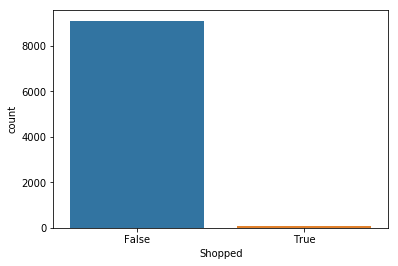

In [66]:
ax = sns.countplot(x="Shopped", data=a)

In [29]:
cons = ((train_df.astype(str).nunique() == 1)[train_df.astype(str).nunique() == 1]).index.values

In [30]:
train_df.drop(labels=cons, axis=1, inplace=True)

In [31]:
train_df.shape # Got rid of the redundant empty columns to save from memory.

(10000, 77)

In [32]:
train_df['device.operatingSystem'].unique()

array(['Windows', 'Chrome OS', 'Android', 'Macintosh', 'iOS', 'Linux',
       '(not set)', 'Windows Phone', 'Samsung', 'Tizen', 'BlackBerry',
       'OS/2', 'Playstation Vita', 'Xbox', 'Nintendo Wii'], dtype=object)

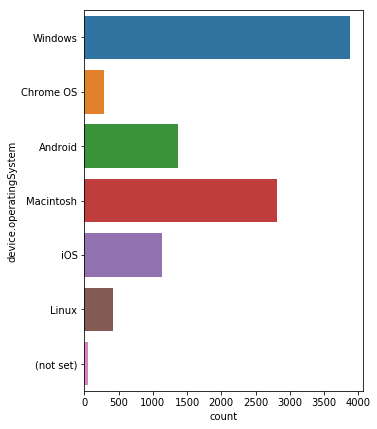

In [50]:
plt.figure(figsize=(5, 7))
sns.countplot(y='device.operatingSystem', data=train_df[train_df['device.operatingSystem'].isin(['Windows', 'Chrome OS', 'Android', 'Macintosh', 'iOS', 'Linux',
       '(not set)'])])

In [51]:
train_df['device.browser'].unique()

array(['Firefox', 'Chrome', 'Safari', 'UC Browser', 'Internet Explorer',
       'Edge', 'Samsung Internet', 'Android Webview', 'Safari (in-app)',
       'Opera Mini', 'Opera', 'YaBrowser', 'Amazon Silk',
       'Mozilla Compatible Agent', 'Puffin', 'Maxthon', 'BlackBerry',
       'ADM', 'Coc Coc', 'MRCHROME', 'Android Browser',
       'Playstation Vita Browser', 'Nintendo Browser'], dtype=object)

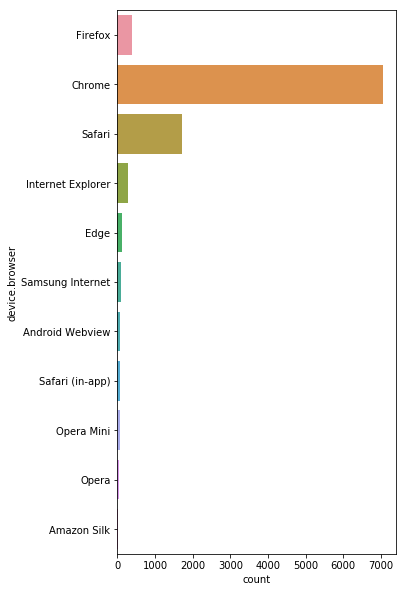

In [55]:
plt.figure(figsize=(5, 10))
sns.countplot(y='device.browser', data=train_df[train_df['device.browser'].isin(['Firefox', 'Chrome', 'Safari', 'Internet Explorer',
       'Edge', 'Samsung Internet', 'Android Webview', 'Safari (in-app)',
       'Opera Mini', 'Opera', 'Amazon Silk'])])

In [57]:
train_df['device.deviceCategory'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

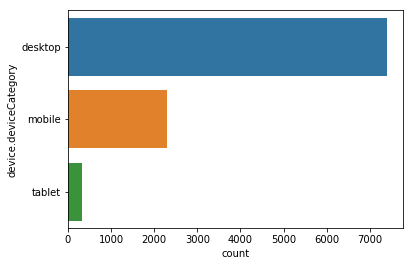

In [58]:
sns.countplot(y='device.deviceCategory', data=train_df)